In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from src.models.time_series_model import TimeSeriesModel
from src.special_preprocessing.first_special_pipeline.pipeline import preprocessing_pipeline
from src.utils import train_test_split_by_months
from sklearn.model_selection import TimeSeriesSplit
from configs.models_collector import ModelsCollector
from configs.models_configs import ModelsConfigs
from src.metrics.forecast_accuracy import forecast_accuracy

In [12]:
real = pd.read_csv("../datasets/first_dataset/decomposed.csv", parse_dates=["date"])
data = pd.read_csv("../datasets/first_dataset/demo_data.csv", parse_dates=["date"])
data = data.sort_values(by=["date"])
X_marked = train_test_split_by_months(data, date_column="date", test_months=1)

In [13]:
selector = ModelsCollector(ModelsConfigs)
trend_models = selector.get_configs(["KNeighborsRegressor", "SVR"])
seasonal_models = selector.get_configs(["XGBRegressor", "CatBoost", "GradientBoostingRegressor"])

In [14]:
tscv = TimeSeriesSplit(n_splits=4)
model = TimeSeriesModel(trend_models, seasonal_models, cv=tscv, scoring="neg_mean_squared_error")

In [15]:
tsm_pipeline = Pipeline(steps=[("preprocessing", preprocessing_pipeline), ("TSM", model)])
tsm_pipeline.fit(X_marked)

/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
36 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/engelsgeduld/miniconda3/envs/pysatl_env/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/enge

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('base preprocessing',
                                  Pipeline(steps=[('nan_handel',
                                                   NaNHandlerTransformer()),
                                                  ('change_types',
                                                   ChangeTypesTransformer()),
                                                  ('key_index',
                                                   KeyIndexTransformer()),
                                                  ('drop_duplicates',
                                                   DropDuplicatesTransformer()),
                                                  ('ohe',
                                                   ColumnTransformer(force_int_remainder_cols=False,
                                                                     remainder='passthrough',
                                                                     transformers=[('OHE...
                                                  (<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>,
                                                   {'learning_rate': array([0.01      , 0.03162278, 0.1       ]),
                                                    'max_depth': [3, 5, 7]})],
                                 trend_models=[(<class 'sklearn.neighbors._regression.KNeighborsRegressor'>,
                                                {'n_neighbors': [3, 5, 10,
                                                                 15]}),
                                               (<class 'sklearn.svm._classes.SVR'>,
                                                {'C': array([  0.1,   1. ,  10. , 100. ]),
                                                 'epsilon': array([0.01      , 0.17333333, 0.33666667, 0.5       ])})]))])

In [16]:
result = tsm_pipeline.predict(X_marked)

In [17]:
forecast_df = pd.merge(result[["date", "key", "Forecast"]], real[["date", "key", "ship"]], on=["date", "key"])
forecast_df["key"] = pd.factorize(forecast_df["key"])[0] + 1
forecast_df = forecast_df.rename(columns={"ship": "Actual"})

In [18]:
forecast_accuracy(forecast_df, time_period="YE")

,date,Actual,Forecast,AE,Acc
0,2023-12-31,5701,5834.024232,133.024232,0.976667


In [19]:
forecast_accuracy(forecast_df, time_period="YE", ae_gr_cols=["key"])

,date,key,Actual,Forecast,AE,Acc
0,2023-12-31,1,1191,1110.504159,80.495841,0.932413
1,2023-12-31,2,269,598.171547,329.171547,-0.223686
2,2023-12-31,3,184,262.093203,78.093203,0.575580
3,2023-12-31,4,0,6.238919,6.238919,0.000000
4,2023-12-31,5,0,13.541263,13.541263,0.000000
5,2023-12-31,6,259,408.803293,149.803293,0.421609
6,2023-12-31,7,2147,1618.582647,528.417353,0.753881
7,2023-12-31,8,0,17.431261,17.431261,0.000000
8,2023-12-31,9,277,392.831624,115.831624,0.581835
9,2023-12-31,10,400,395.197730,4.802270,0.987994


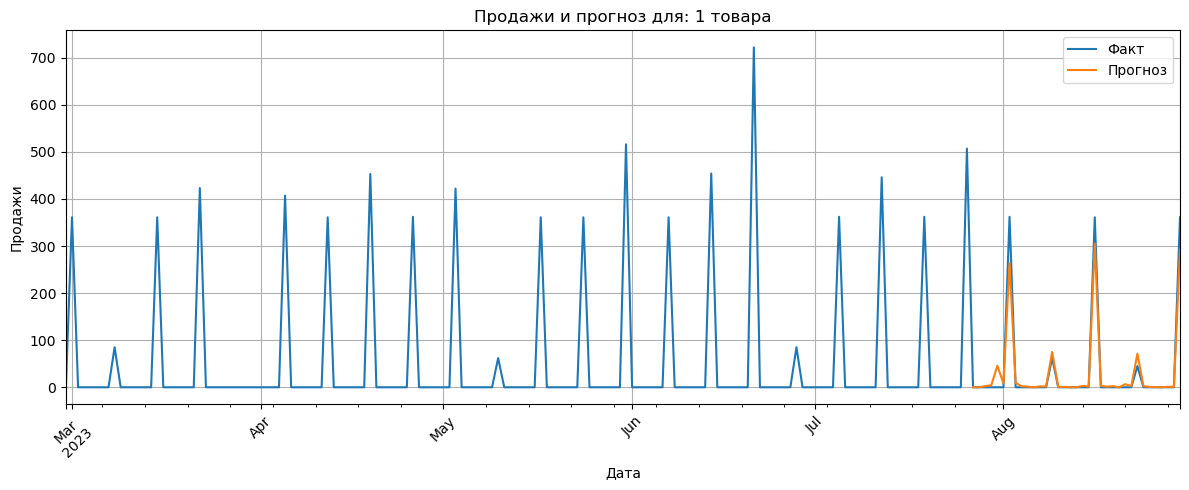

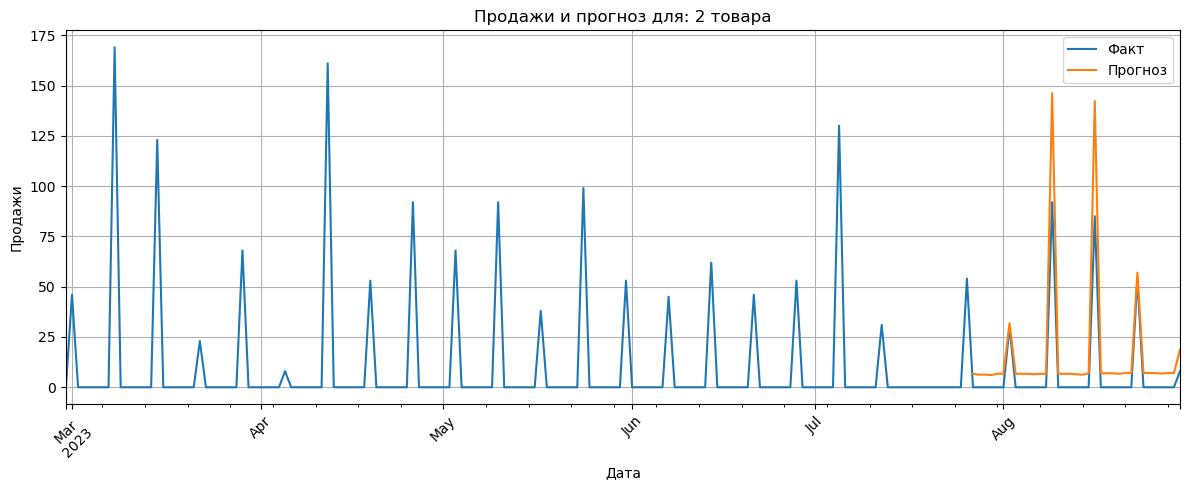

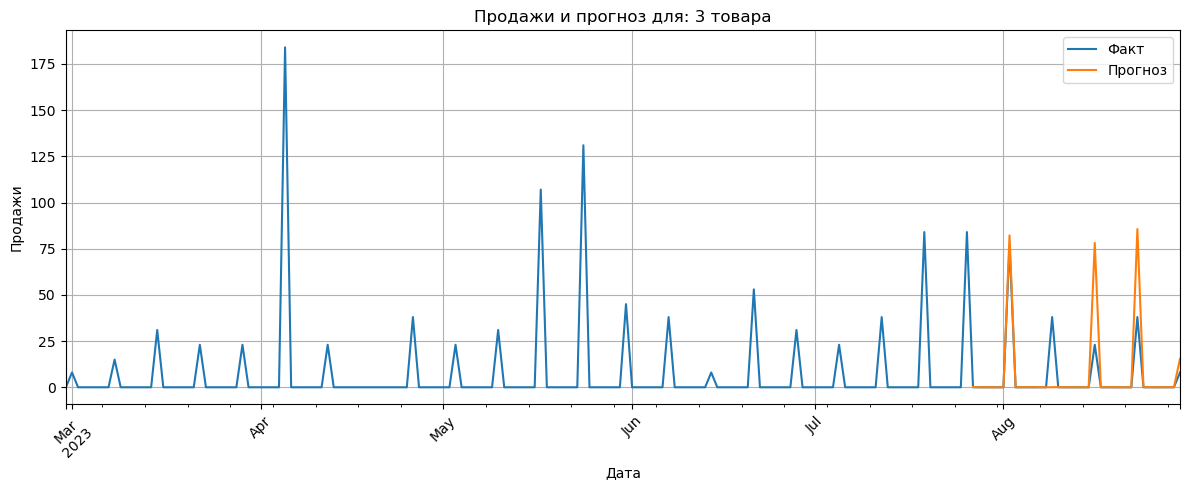

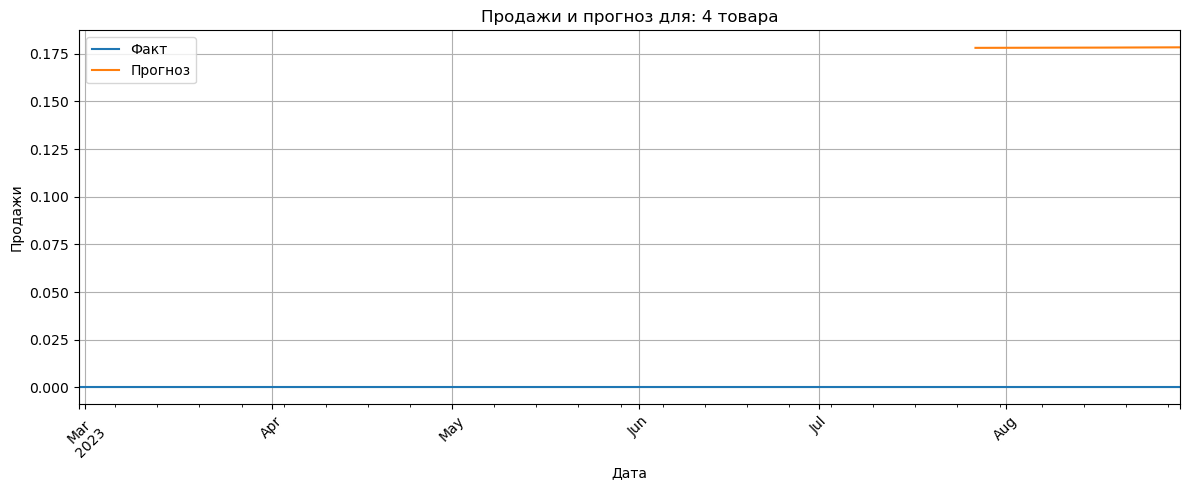

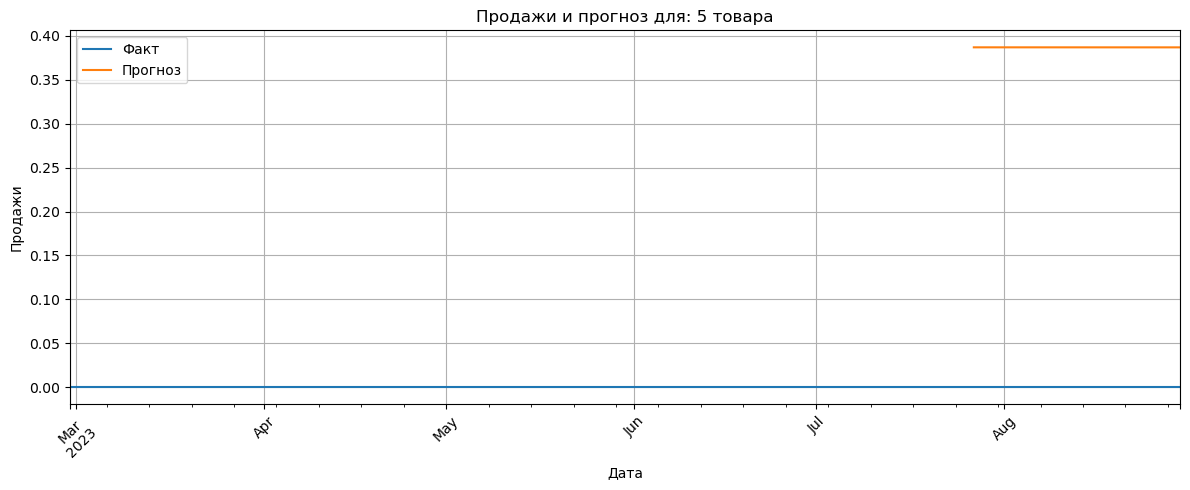

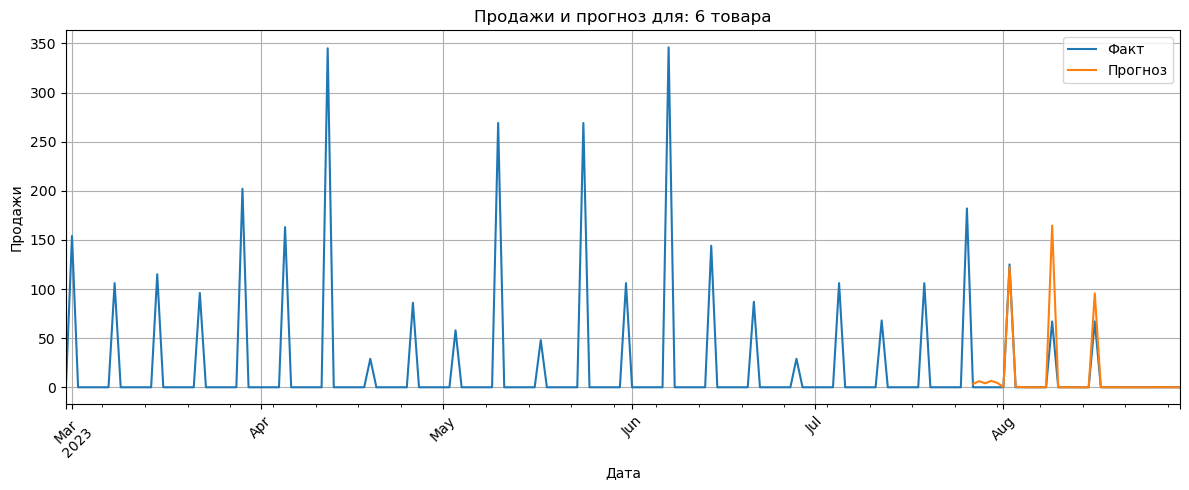

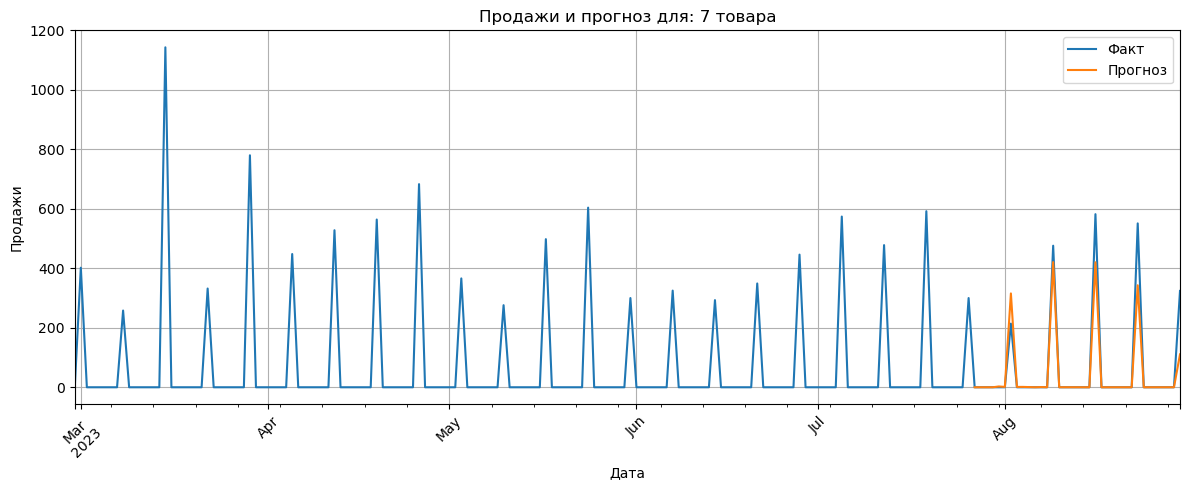

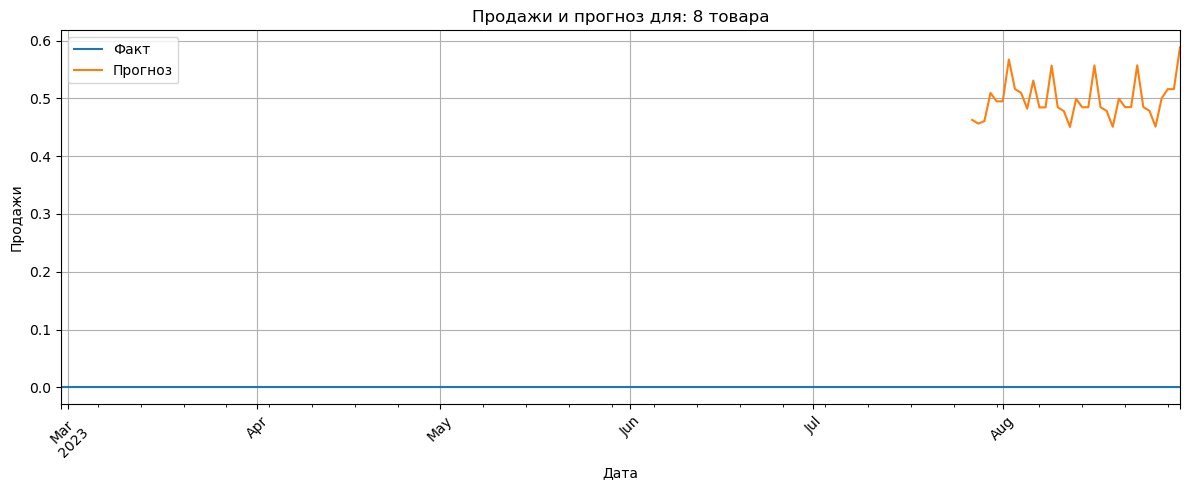

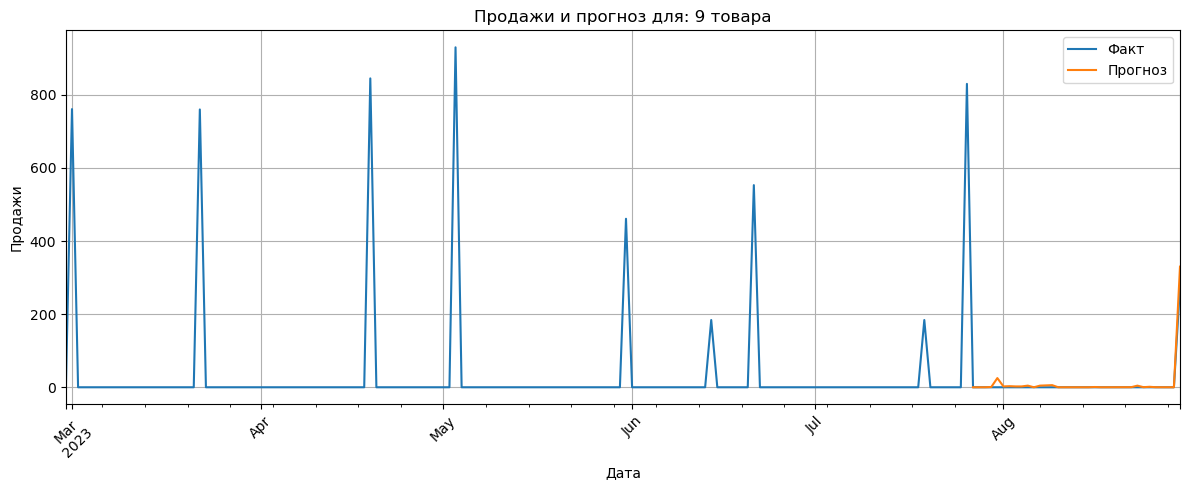

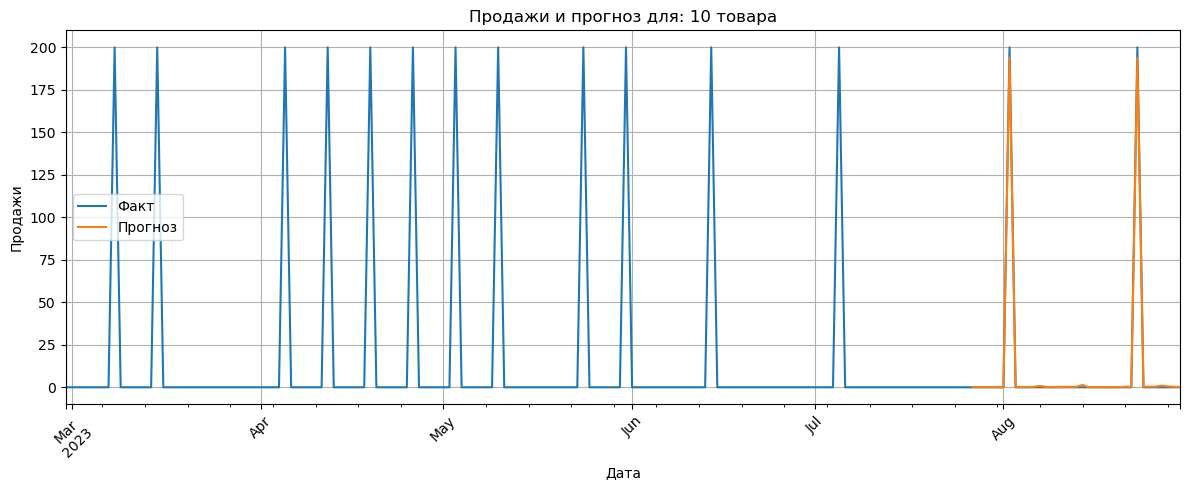

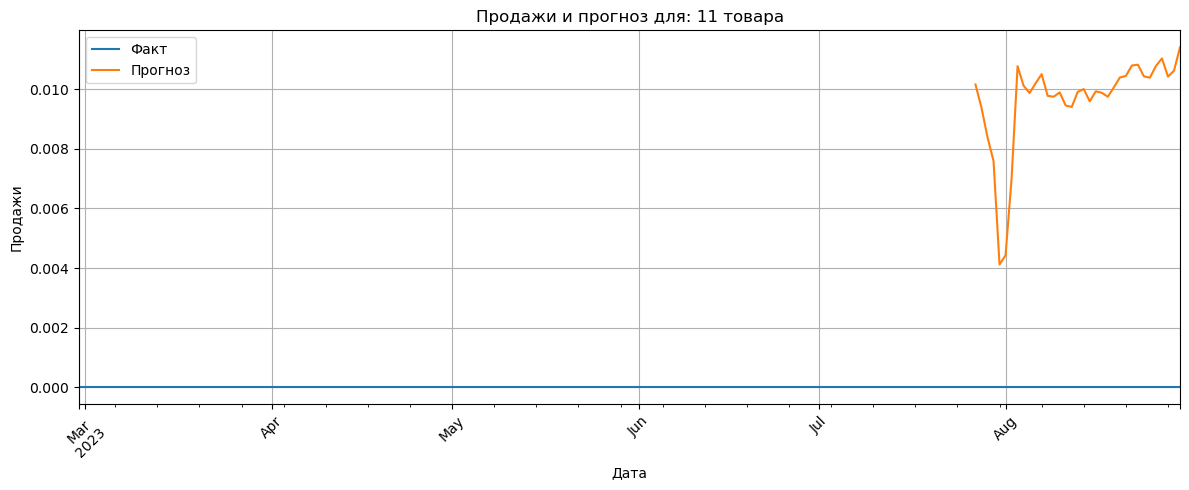

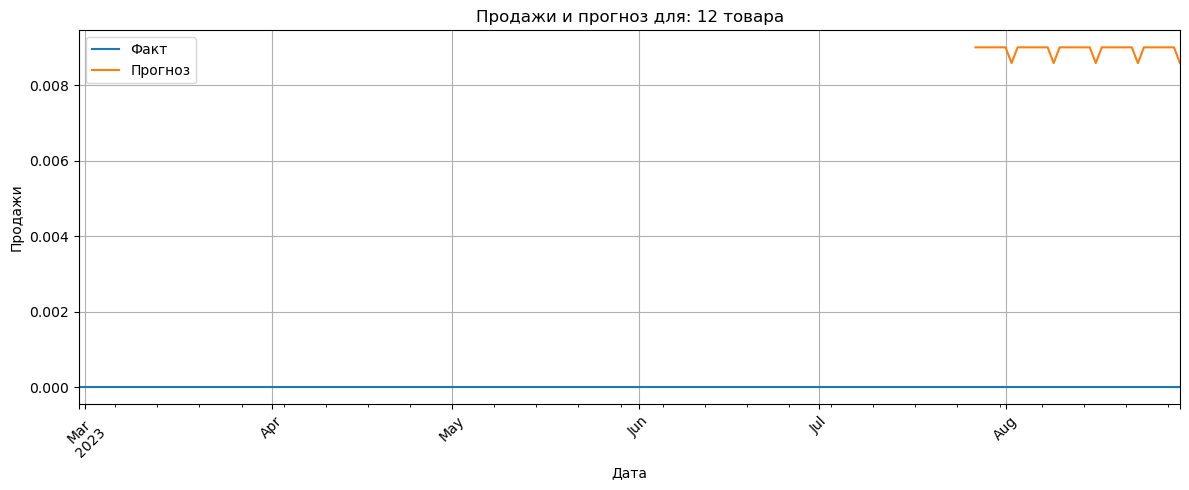

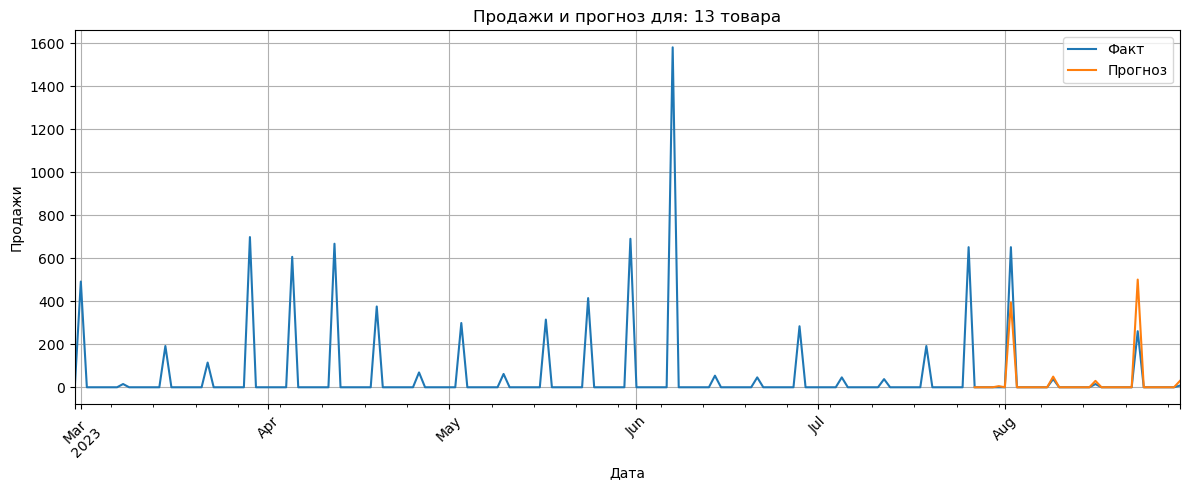

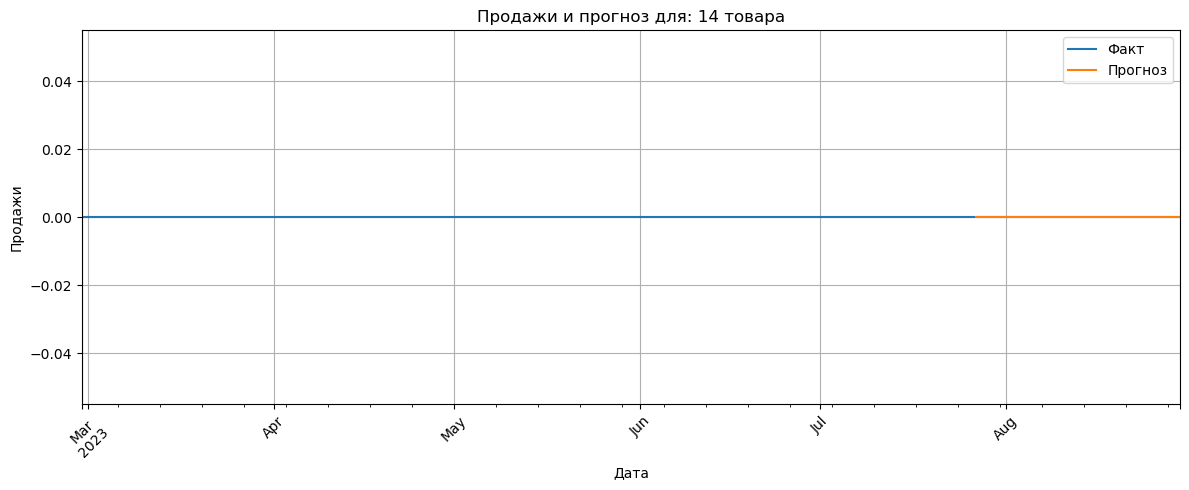

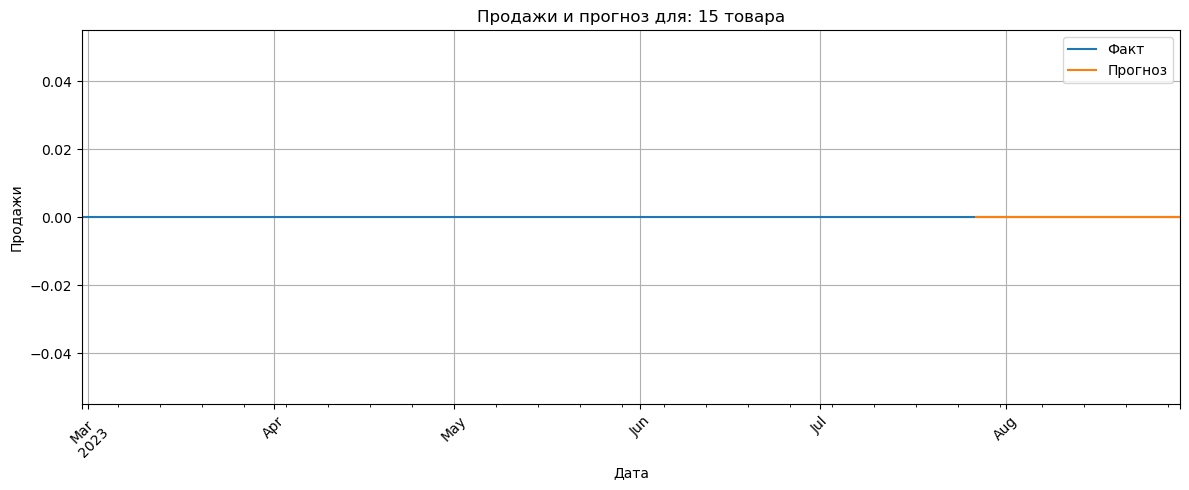

In [21]:
keys = result["key"].unique()

for idx, key in enumerate(keys, 1):
    pred_key_df = result[result["key"] == key]
    last_pred_date = pred_key_df["date"].max()
    start_date = last_pred_date - pd.DateOffset(months=6)

    real_key_df = real[(real["key"] == key) & (real["date"] >= start_date) & (real["date"] <= last_pred_date)]

    pred_key_df = result[result["key"] == key]

    combined_df = pd.merge(
        real_key_df[["date", "key", "ship"]], pred_key_df[["date", "key", "Forecast"]], on=["date", "key"], how="outer"
    )

    combined_df = combined_df.sort_values("date").set_index("date")

    combined_df[["ship", "Forecast"]].plot.line(figsize=(12, 5), title=f"Продажи и прогноз для: {idx} товара")
    plt.xlabel("Дата")
    plt.ylabel("Продажи")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.legend(["Факт", "Прогноз"])
    plt.tight_layout()
    plt.show()